# Loosely Coupled Sensor Fusion.
## IMU + GNSS for quadrotor dynamic

In [183]:
import numpy as np
import scipy.io as scyIO 
import os
import matplotlib.pyplot as plt

In [184]:
# Define constants 
Ts = 0.01
gravity = 9.81

dt = Ts

In [185]:
def q2dcm(q,_raw = False):
    
   #Function for transformation from quaternions to directional cosine matrix
   #Farell pp.41
   #Edit: MAtteo

    qx = float(q[0])
    qy = float(q[1])
    qz = float(q[2])
    qw = float(q[3])
    
    if _raw:
        DCM = np.array([[1 - 2*qy**2 - 2*qz**2,2*qx*qy - 2*qz*qw,2*qx*qz + 2*qy*qw],
                        [2*qx*qy + 2*qz*qw,1 - 2*qx**2 - 2*qz**2,2*qy*qz - 2*qx*qw],
                        [2*qx*qz - 2*qy*qw,2*qy*qz + 2*qx*qw,1 - 2*qx**2 - 2*qy**2]
                        ])#.T ????
    else:
        p = np.array([qx**2,qy**2,qz**2,qw**2,qy + qz,0])
        
        if p[0]+p[3]+p[4] <= -1e12 or p[0]+p[3]+p[4] >= -1e12:
            p[5]=2/(p[0] + p[3]+p[4]) 
        else:
            p[5]=0
    
        DCM =np.zeros((3,3))
        
        DCM[0,0] = 1 - p[5] * p[4]
        DCM[1,1] = 1 - p[5] * (p[0]+p[2])
        DCM[2,2] = 1 - p[5] * (p[0]+p[1])
        
        p[0] = p[5] * q[0]; 
        p[1] = p[5] * q[1];
        p[4] = p[5] * q[2] * q[3];
        p[5] = p[0] * q[1];
        
        
        DCM[0,1] = p[5] - p[4];
        DCM[1,0] = p[5] + p[4];
        
        p[4] = p[1] * q[3];
        p[5] = p[0] * q[2];

        DCM[0,2] = p[5] + p[4];
        DCM[2,0] = p[5] - p[4];
        
        p[4] = p[0]* q[3];
        p[5] = p[1]* q[2];

        DCM[1,2] = p[5] - p[4];
        DCM[2,1] = p[5] + p[4];
        
    DCM = DCM.reshape(3,3)
    return DCM



In [186]:
q_test = np.array([0.707, 0.707,0,0]).reshape(4,1)
v_test = np.array([1,0,0]).reshape(3,1);

DCM_nraw = q2dcm(q_test)
DCM_raw = q2dcm(q_test, True)

print(DCM_nraw)
print(DCM_raw )


print(np.dot(DCM_nraw,DCM_nraw.T))
print(np.dot(DCM_raw,DCM_raw.T) )

[[-0.17164616  0.82835384  0.        ]
 [ 0.82835384  0.17164616  0.        ]
 [ 0.          0.         -0.65670767]]
[[ 3.02000e-04  9.99698e-01  0.00000e+00]
 [ 9.99698e-01  3.02000e-04  0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -9.99396e-01]]
[[ 7.15632485e-01 -3.62587187e-18  0.00000000e+00]
 [-3.62587187e-18  7.15632485e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  4.31264969e-01]]
[[9.99396182e-01 6.03817592e-04 0.00000000e+00]
 [6.03817592e-04 9.99396182e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.98792365e-01]]


In [187]:
#Test for a rotation about z of 90°


dcm_test = q2dcm(q_test)
print(dcm_test)
v_test_rot = np.dot(dcm_test , v_test)

print(v_test_rot,v_test_rot.shape, np.linalg.norm(v_test_rot))

[[-0.17164616  0.82835384  0.        ]
 [ 0.82835384  0.17164616  0.        ]
 [ 0.          0.         -0.65670767]]
[[-0.17164616]
 [ 0.82835384]
 [ 0.        ]] (3, 1) 0.8459506396538023


____________________________________________________________________
## Governing Equations

$state  \rightarrow \mathbf{x} $
 
 $\mathbf{x} = \{p_x, p_y, p_z,v_x, v_y, v_z, q_x, q_y, q_z, q_w\}^T $  , $ \mathbf{x} \in \mathbb{R}^{10}$


$ measurement(IMU) \rightarrow \mathbf{\tilde{u}}$  

$ \mathbf{\tilde{u}}= \{a_x, a_y, a_z, \omega_x,\omega_y,\omega_z\}^T \triangleq \{ \mathbf{s}, \boldsymbol{\omega}\} $, $ \mathbf{\tilde{u}} \in\mathbb{R}^{6} $    </br>

*accelerometers are meant to detect external accelerations (and rotations) in the Body refence frame ($\mathcal{B}$).<br> Obviously GPS will provide any position information in an absolute reference frame:* ($\mathcal{N}$)

*where:*
$ \mathbf{v} \lvert_{\mathcal{N}} =  \mathbf{R}^n_b (\mathbf{q})   \mathbf{v} \lvert_{\mathcal{B}}$


1. $\mathbf{p_k} = \mathbf{p_{k-1}} + T_s \mathbf{v_{k-1}} + (T_s^2) [ \mathbf{R_b^n}(\mathbf{q_{k-1}})\mathbf{s_{k-1}} - \mathbf{g}]$ *(position in $\mathcal{N}$ reference frame)*

<br>

2. $\mathbf{v_k} = \mathbf{v_{k-1}} + (T_s) [ \mathbf{R_b^n}(\mathbf{q_{k-1}})\mathbf{s_{k-1}} - \mathbf{g} ] $ *(velocity in $\mathcal{N}$ reference frame)*

<br>

3. $\mathbf{q_k} =  [ cos(\frac{1}{2} \frac{T_s}{\lvert\lvert \boldsymbol{\omega} \lvert\lvert^2}) \mathbf{I_4} +sin(\frac{1}{2} \frac{T_s}{\lvert\lvert \boldsymbol{\omega} \lvert\lvert^2}) \boldsymbol{\Omega_k}] \mathbf{q_{k-1}} $ 
   
   (*quaternion's kinematic. **NB**: this quaternions are the ones for rotation: $\mathcal{B} \rightarrow \mathcal{N}$*)

*where* $\boldsymbol{\Omega_k} = \left[\begin{array} {c,c,c,c}
                                         0 ,\omega_z , -\omega_y , \omega_x \\
                                        -\omega_z , 0 , \omega_x , \omega_y \\
                                        \omega_y , -\omega_x , 0 , \omega_z \\
                                        -\omega_x , -\omega_y , -\omega_z ,0 
                                        \end{array} \right]$
        
 *and* $\mathbf{R_b^n}(\mathbf{q}) = \left[\begin{array} {c,c,c}
                                           q_w^{2}+ q_x^2− q_y^2 − q_z^2, ... ,.. \\
                                           ..., ... , ... \\
                                           ..., ...., ...
                                             \end{array} \right]$
                                             
 $\small{refer \quad to : \text{http://www.tu-berlin.de/fileadmin/fg169/miscellaneous/Quaternions.pdf}}$

**NOTE:** *implemented algortithm avoid singularity*: $q_x^{2} + q_w^{2} + q_x-q_w = 0$

##### Key-Point: 
*IMU sensor model is modeled as the sum of a bias error measurement following a "random-walk-dynamic".*

$ \mathbf{\tilde{u}} = \mathbf{u} - \mathbf{\delta u}_k + \mathbf{w}^{(1)}$
<br> *where*<br>
     $ \mathbf{\delta u}_k = \mathbf{\delta u}_{k-1} + \mathbf{w}^{(2)} $
     
     
  *Moreover $\mathbf{w}^{(1)}$ and $\mathbf{w}^{(2)}$ are uncorrelated with covariance matrices: $\mathbf{Q^{(1)}}, \mathbf{Q^{(2)}}$respectively*
____________________________________________________________________

In [188]:
def gravity(x):
    #
    g_0 = np.array([0,0,-9.81]).reshape(3,1)
    return g_0

def nav_equations(x,u,dt):
    ### traslation
    pv = x[:6]
    q = x[6:]
    A = np.eye(6)
    
    A[0,3] = dt
    A[1,4] = dt
    A[2,5] = dt #here implements simple integrator: x[t] = x[t-1] + vx * dt
    
    f_t = np.dot(q2dcm(q),u[:3])
    acc_t = f_t - gravity(x)
    
    B = np.concatenate((np.eye(3,3) * dt**2/2,np.eye(3,3) * dt))
    
    x_pv = np.dot(A,x[:6])+ np.dot(B,f_t)
    
    ### rotation
    w_t = u[3:]
    P = w_t[0] * dt
    Q = w_t[1] * dt
    R = w_t[2] * dt
    
    
    OMEGA = np.array([[0, R, -Q, P],
                      [-R, 0, P, Q],
                      [Q, -P, 0, R],
                      [-P, -Q, -R, 0]])
    
    V = np.linalg.norm(w_t) * dt
    
    x_rot = np.dot(np.cos(V/2) * np.eye(4) + 2/V * np.sin(V/2) * OMEGA ,x[6:])
    
    x = np.zeros((10,1))
    x[:6] = x_pv
    x[6:] = x_rot
    
    return x

### Test
x_test = np.array([1,1,0,0.1,0.1,0,q_test[0],q_test[1],q_test[2],q_test[3]]).reshape(10,1)
u_test = np.array([1,0,0,1,2,0]).reshape(6,1)
x_test_t = navEq(x_test,u_test,dt)
print(x_test_t)
print(x_test_t.shape)

[[ 1.00099142]
 [ 1.00104142]
 [ 0.        ]
 [ 0.09828354]
 [ 0.10828354]
 [ 0.        ]
 [ 0.70695581]
 [ 0.70695581]
 [ 0.00706985]
 [-0.02120956]]
(10, 1)


____________________________________________________________________

## State-Space Equations

*Instead of filetering the proper system's dynamic (which can always be filtered separately), the current implementation apply the filter to errors dynamic.*

$ \mathbf{z}_k = \{\mathbf{\delta x}, \mathbf{\delta u}\} \in \mathbb{R}^{15} $
    $ \Rightarrow$
$ \mathbf{z} =\{\mathbf{\delta p_{3 \times 1}},
                \mathbf{\delta v_{3 \times 1}},
                \boldsymbol{\delta \epsilon_{3 \times 1}} \lvert
                \mathbf{\delta w^{(1)}_{3 \times 1}}
                \mathbf{\delta w^{(2)}_{3 \times 1}}\}  $

***where***: <br>
*1. the minimal attiture representation is kept, replacing quaternions with $\epsilon$, wich actually is the **small-rotations** difference* 
 
$\boldsymbol{\delta \epsilon } \quad  s.t. \quad \exists \quad \Gamma (\mathbf {q}, \boldsymbol{\epsilon}) \triangleq \{ \mathbf{q} \in SO^3 \quad \lvert \quad \mathbf{R_b^n}(\mathbf{q}) = [\mathbf{I_3} - [\boldsymbol{\epsilon}]_{\times} ] \mathbf{R_b^n}(\mathbf{\hat{q}})   \} $

$[\mathbf{\epsilon}]_{\times}=\left[\begin{array} {c,c,c}
                                           0, \epsilon_y , -\epsilon_z \\
                                           \epsilon_z, 0 , \epsilon_x \\
                                           \epsilon_x, -\epsilon_y, 0
                                             \end{array} \right]$
                                             
                                             
*As the filter computes small (infinitestimal) rotations errors the corrections on quaternions must be performed as follow:*

$KF\quad \rightarrow \quad \boldsymbol{\delta \epsilon} \quad \rightarrow  \quad
\mathbf{R_b^n}(\mathbf{\hat{q}}) = (\mathbf{I}_3 - [\mathbf{\epsilon}]_{\times} )\mathbf{R_b^n}(\mathbf{q}) \quad  \rightarrow \quad  \mathbf{\hat{q}} \quad \tiny{\text{ ( final step to be performed with DCM2q) }} $


                                              

*2. estimation error:* <br> 

$ \mathbf{\delta x} = \mathbf{\hat{x}} - \mathbf{x} $ 
( * estimated - true *),
<!-- $\mathbf{\delta u} = \mathbf{\hat{u}} - \mathbf{u} $-->




<img src="./Loosely_coupled_Kf.png"/>


**NOTE**: *the filter is going to correct the error relying on GPS measurement, therefore the covariance of observation noise ($\mathbf{R}$) is equal to the GNSS measurement* 

________________________________________________________________________


In [189]:
def state_space_model(x,u,Ts):
    q = x[6:]
    Rb2n = q2dcm(q)
    
    #hate numpy => need to specify float for each element
    for i in range(0,3):
        for j in range(0,3):
            Rb2n[i,j] = float(Rb2n[i,j])
            
    # rotate accelerometer(s) measurement in absolute frame
    f_n = np.dot(Rb2n,u[:3])
    # Submatrix implementing: [Rb2n * fn]X ( skew matrix)
    Sn = np.array([[0 ,float(-f_n[2]), float(f_n[1])],
                    [float(f_n[2]), 0, float(-f_n[0])],
                    [float(-f_n[1]), float(f_n[0]), 0]])
    
    
    O = np.zeros((3,3))
    I = np.eye(3,3)
    
    #F = np.zeros((15,15))
    Rb2n = Rb2n.reshape((3,3))
    Fc = np.block([[O, I ,  O,     O,    O],
                   [O, O,  Sn,  Rb2n,    O],
                   [O, O,  O,      O,-Rb2n],
                   [O, O ,  O,     O,    O],
                   [O, O ,  O,     O,    O]])#size 15 X 15
    
    F = np.eye(15,15) + Ts * Fc
    
    G= Ts*np.block([[ O  ,  O , O ,O],
                    [ Rb2n ,O , O ,O],
                    [ O, -Rb2n, O ,O],
                    [ O,   O  , I ,O],
                    [ O,   O  , O ,I ]])#size 15 X 12
    
    
    
    return F,G
    

F_test, G_test = state_space_model(x_test,u_test,Ts)

dz_test = np.ones((15,1))
w_test = np.ones((12,1))
dz_test_t = np.dot(F_test,dz_test) + np.dot(G_test,w_test)
print(dz_test_t, dz_test.shape)

[[1.01      ]
 [1.01      ]
 [1.01      ]
 [1.02141769]
 [1.02171646]
 [0.97686585]
 [0.98686585]
 [0.98      ]
 [1.01313415]
 [1.01      ]
 [1.01      ]
 [1.01      ]
 [1.01      ]
 [1.01      ]
 [1.01      ]] (15, 1)


## Sensors' data 
*1. Structure sensor(s) data*<br>
*2. plot time-series* <br>
*2. Fit Covariance*

In [190]:
# Load the .mat file:
files = os.listdir(os.getcwd()+'/../GPSaidedIMU')
in_data = [os.getcwd()+'/../GPSaidedIMU/' + f   for f in files  if ".csv" in f ]
mats = [os.getcwd()+'/../GPSaidedIMU/' + f   for f in files  if ".mat" in f ]

mats
in_data


['/Users/teobaiguera/Documents/Study/Kalman_Cpp/python/../GPSaidedIMU/ACC_data.csv',
 '/Users/teobaiguera/Documents/Study/Kalman_Cpp/python/../GPSaidedIMU/GNSS_data.csv',
 '/Users/teobaiguera/Documents/Study/Kalman_Cpp/python/../GPSaidedIMU/GYRO_data.csv']

In [191]:
class SensorData:
    delimiter = ","

    def __init__(self,datafile_,name):
        self.__data = np.loadtxt(datafile_, delimiter = SensorData.delimiter)
        self.__time = self.__data[:,0]
        self.__readings = self.__data[:,1:]
        
        self.name = name
        self.tmax = self.__time[-1];
        
        self.Ts = 0
        self.Qcov = None
        self.last_idx = 0
        
        for i in range(len(self.__time[1:])):
            dt = self.__time[i] - self.__time[i-1]
            if dt > self.Ts:
                self.Ts = dt
            
    def __getitem__(self,idx):
        try:
            assert(idx < len(self.__time))
        except IndexError:
            
            print("OUT OF RANGE")
            return None , None
        
        return self.__readings[idx]
    
    
    def t(self,idx):
        
        try:
            assert(idx < len(self.__time))
        except IndexError:
            
            print(" TIME OUT OF RANGE")
            return None , None
        
        return float(self.__time[idx])

    def at(self, t):
        # Enable Check for GNSS availability
        if t < self.__time[-1]  and  t >= self.__time[self.last_idx]:
            
            time_idx = np.array([ idx for idx,tt in enumerate(self.__time) if tt <= t])
            self.last_idx = time_idx[-1]
            
            return self.__readings[time_idx[-1]]
        else:
            return None
        
        
    def plot(self):
        names = [self.name +'_1', self.name +'_2', self.name +'_3']
        plt.plot(self.__time,self.__readings)
        plt.legend(names)
        plt.xlabel('time(s)')
        plt.ylabel('readings')
        plt.show()
        
    def gettime(self):
        return self.__time
    
    def getdata(self):
        return self.__readings
    
    def sigma_fit(self):
        print(np.cov(self.__readings))

[-1.01938165 -0.97581071 -9.89077144]
0.0100000000000193
[-0.96618058 -0.89743596 -9.78652675]


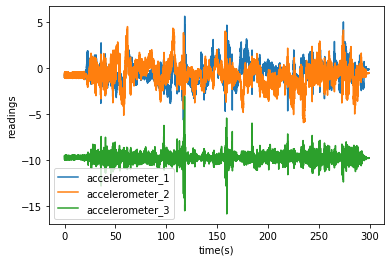

In [192]:
accelerometer = SensorData(os.getcwd()+'/../GPSaidedIMU/ACC_data.csv',"accelerometer")
print(accelerometer[31])
print(accelerometer.t(1))
print(accelerometer.at(1))

accelerometer.plot()


OK sensor samples at same time => as they acquire at same time!!


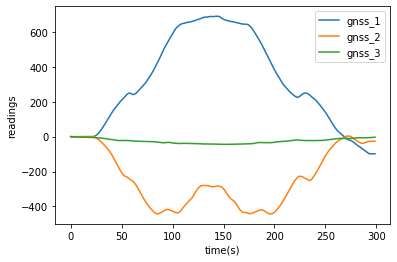

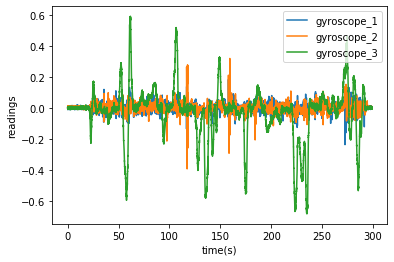

In [193]:
gyroscope = SensorData(os.getcwd()+'/../GPSaidedIMU/GYRO_data.csv',"gyroscope")
gnss = SensorData(os.getcwd()+'/../GPSaidedIMU/GNSS_data.csv',"gnss")

try:
    assert(gyroscope.Ts == accelerometer.Ts )
    for g,a in zip(gyroscope.gettime() , accelerometer.gettime()):
        assert(g == a)
    print("OK sensor samples at same time => as they acquire at same time!!")
except:
    print("no same Ts for accelerometer")
    
gnss[3]
gnss.plot()
gyroscope.plot()

In [199]:
a = np.array([1,23,4])
(a**2).reshape(3,1)

array([[  1],
       [529],
       [ 16]])

### Kalman fliter 
#### Filter is on  sensor(s) error measurement error.


In [272]:
a = np.zeros((15,1))
aa = np.vstack([np.zeros((9,1)),a[9:]])
print(a[9:].shape)
aa.shape

A = np.array([[12,3,4],[1,2,3],[1,2,22],[12,3,4],[1,2,3],[1,2,22]])
A[:2,:2]

(6, 1)


array([[12,  3],
       [ 1,  2]])

In [220]:
class KalmanFilterLooselyIMUGNNS:
    def __init__(self,Q1,Q2,z0,
                 p_uncertainty = 10 , v_uncertainty = 5, 
                 rpy_uncertainty = [np.pi/180.0 * 1.,np.pi/180.0 * 1., np.pi/180.0 * 20.],
                 acc_biases = 0.02, gyro_biases = 0.05*np.pi/180,
                 gnss_uncertainty =np.sqrt(3)):
        
        # Measurement (output) matrix, a.k.a filter's observation matrix ( from GNSS)
            #=>  H s.t. y_k -y_GNSS_k =  p_gps - p_estimate = delta_y = H * z_k + ek
        O = np.zeros((3,3))
        self.H = np.hstack([np.eye(3),O,O,O,O])
        assert(self.H.shape == (3,15))
        
        # measurement covariance:
        self.R = (gnss_uncertainty**2) * np.eye(3)
        
        # Process covariance:
        self.Q1 = Q1
        self.Q2 = Q2
        
        O1 = np.zeros((self.Q1.shape[0],self.Q2.shape[1] ))
        O2 = np.zeros((self.Q2.shape[0],self.Q1.shape[1] ))
                      
        self.Q = np.array([[self.Q1,O1],
                           [O2,self.Q2]]).reshape((self.Q1.shape[0]+self.Q2.shape[0], 
                                              self.Q1.shape[1]+ self.Q2.shape[1] ))
        
        #Filter state:
        self.z = z0
        #Filter state-covariance: 
            # !! As rpy_uncertainty is approximated to small angles  
            # => epsilon = rpy_uncertainty
            
        p = np.vstack([(p_uncertainty**2) * np.ones((3,1)), 
                       (v_uncertainty**2) * np.ones((3,1)),
                       (np.array(rpy_uncertainty)**2).reshape((3,1)),
                       (acc_biases**2) * np.ones((3,1)),
                       (gyro_biases**2) * np.ones((3,1))])
    
        print(p.shape)
        assert(p.shape == (15,1))
        
        self.P = np.eye(15) * p 
        assert(self.P.shape == (15,15))
        
        
        #Init gain to null
        self.K = None
                      
                      
                      
    
    #As F,G depend on the state => 
    def predict(self,F,G):
        #% P=F*P*F'+G*blkdiag(Q1,Q2)*G';
        self.P = np.dot(F , np.dot(self.P , F.T) ) + np.dot(G , np.dot(self.Q,G.T))

    def compute_gain(self,F,G):
        #%K=(P*H')/(H*P*H'+R);
        self.K = np.dot(np.dot(np.dot(self.P,self.H.T), 
                        np.inv(np.dot(self.H, np.dot(self.P, self.H.T)) + self.R)))
        
    def update(self,delta_u_h,y,x ):
        #% z=[zeros(9,1); delta_u_h]+K*(y-H(:,1:6)*x_h(1:6));
        #% P=(eye(15)-K*H)*P;
        z_ = np.vstack(np.zeros((9,1)), self.z[9:])# Keep only sensor's biases
        
        #?? WTF: try to avoid this step ?? 
        H_ = self.H[:6,:6]#remove attitude observation
        x_ = x[:6]#remove quaternions
        
        
        self.z = z_ +  np.dot(K,(y - np.dot(H_,x_)))
        self.P = np.dot((np.eye(15) - np.dot(self.K,self.H)), self.P)
        
        pass
        
        
        
        
        
    

In [235]:
delta_u_h = np.zeros((6,1))
z0 = np.concatenate([np.zeros((9,1)), delta_u_h])

In [236]:
#Q are provided by literature (tutorial)
sigma_acc = 0.05; #% [m/s^2]
sigma_gyro = 0.1*np.pi/180; #% [rad/s]
sigma_acc_bias = 0.0001; #% [m/s^2.5]
sigma_gyro_bias = 0.01*np.pi/180; #% [rad/s^1.5]

q1_acc = sigma_acc* np.ones((3,1))
q1_gyro = sigma_gyro * np.ones((3,1))
q1 = np.concatenate((q1_acc, q1_gyro))
Q_1 = np.eye(6) * q1

q2_acc = sigma_acc_bias* np.ones((3,1))
q2_gyro = sigma_gyro_bias * np.ones((3,1))
q2 = np.concatenate((q2_acc, q2_gyro))

Q_2 = np.eye(6) * q2

delta_u_h = np.zeros((6,1))
z0 = np.concatenate((np.zeros((9,1)), delta_u_h))

kf = KalmanFilterLooselyIMUGNNS(Q_1,Q_2, )




(15, 1)


### Program

In [222]:
t_spn_acc = len(accelerometer.gettime())
t_spn_gyro = len(gyroscope.gettime())
t_spn_gnss = len(gnss.gettime())
t_spn = max(t_spn_acc, t_spn_gyro, t_spn_gnss)

In [223]:
# Init: current time
t_imu_k_ = 0

# Init:  IMU bias calibration

u = np.concatenate((accelerometer[0],gyroscope[0])).reshape(6,1)

#Init: state & buffer-state
q_h =  np.array([0.0214 ,-0.0539,-0.3399,0.9387]).reshape(4,1)
x_h = np.concatenate(( np.zeros((6,1)), q_h )).reshape(10,1)
x_spn = np.zeros((t_spn,10))


for k in range(1,t_spn):
    
    # Get (current) sampling time
    assert(gyroscope.t(k) == accelerometer.t(k))
    t_imu_k = accelerometer.t(k)
    Ts = t_imu_k - t_imu_k_
    
    t_imu_k_ = t_imu_k
    
    # Calibrate sensor's bias model
        # according to sensor's model: du = u - du 
        # u_h -> calibrated, u -> raw 
        # delta_u_h -> obtained from kalman-filter on s.s. model
    u_h = u - delta_u_h
    assert(u_h.shape == (6,1))
    
    # Update-step: propagate navigation equation
    assert(x_h.shape == (10,1))
    x_h = nav_equations(x_h, u_h, Ts)
    
    # Get State-Space model => error(s) dynamic propagation:
    F,G = state_space_model(x_h, u_h,Ts)
    assert(F.shape == (15,15) and G.shape == (15,12))
    
    
    #Predict covariance
    kf.predict_covariance(F,G)
    
    #
    
    
    